In [1]:
import csth.utils.pmaps_functions           as pmapsf
import csth.utils.hpeak_pmaps_newfunctions  as hppmap

import krcal.dev.corrections                as corrections

from csth.images.imageDataFrame        import imageDataFrame
from invisible_cities.database.load_db import DataSiPM

import csth.images.voxelization as vx
import csth.images.blob         as b

from csth.images.IMAGE import IMAGE

import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.patches  as patches
import matplotlib.gridspec as gridspec

from scipy                   import optimize
from scipy.integrate         import quad

In [2]:
# Plotting style
figure_size  = 9, 5
#font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
#plt.rcParams[  "font.size"   ] =   font_size

#plt.style.use(plt.style.available[10])

# 1. EXAMPLE

## Event data

In [3]:
run  = 6206
ev   = 5527071
loc  = 50
typo = 'Tlds'

In [4]:
datasipm = DataSiPM(run)
xpos, ypos = datasipm.X.values, datasipm.Y.values

correction_filename = f'/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5'
calibrate = corrections.Calibration(correction_filename, 'scale')

datadir  = f'/home/gonzalo/Documentos/NEXT/CsThNB/GDL/selected_pmaps/{run}/pmaps_{loc}_{run}_{typo}.h5'
data     = pd.HDFStore(datadir)

s1   , s2   , s2si    = data['s1']      , data['s2']      , data['s2si']
s1_ev, s2_ev, s2si_ev = s1[s1.event==ev], s2[s2.event==ev], s2si[s2si.event==ev]

pmap=(s1_ev, s2_ev, s2si_ev)
x0ij, y0ij, z0ij, eij, qij = hppmap.get_event_hits(pmap, calibrate, xpos, ypos)

calibration file : /home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run6206.h5
node             : scale
Energy   scale : 10069.6 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale : 598.7 (pes)


## Image

In [5]:
imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = x0ij, y0ij, z0ij, eij

<IPython.core.display.Javascript object>


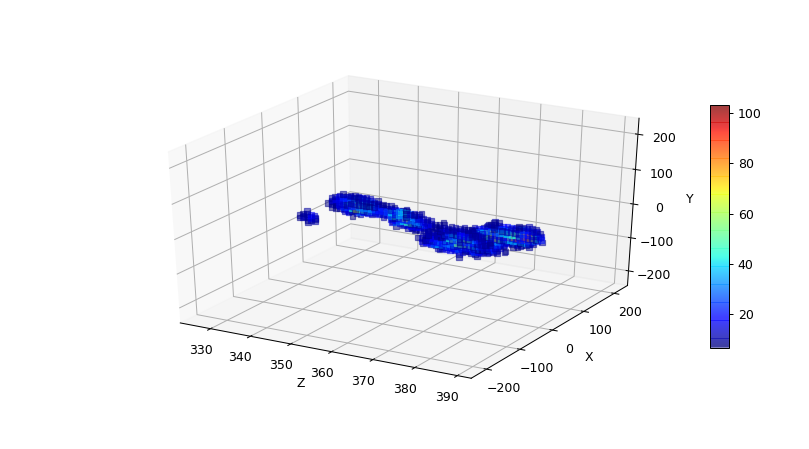

In [6]:
im = IMAGE(imagedf, datasipm, run, ev, typo)
im.plot3d()
im.fig.show();

# Rebined image

In [7]:
rx, ry = 1, 1
zd = -1
imdf = vx.imageDataFrame(imagedf, datasipm, rx, ry, zd, th=0)

<IPython.core.display.Javascript object>


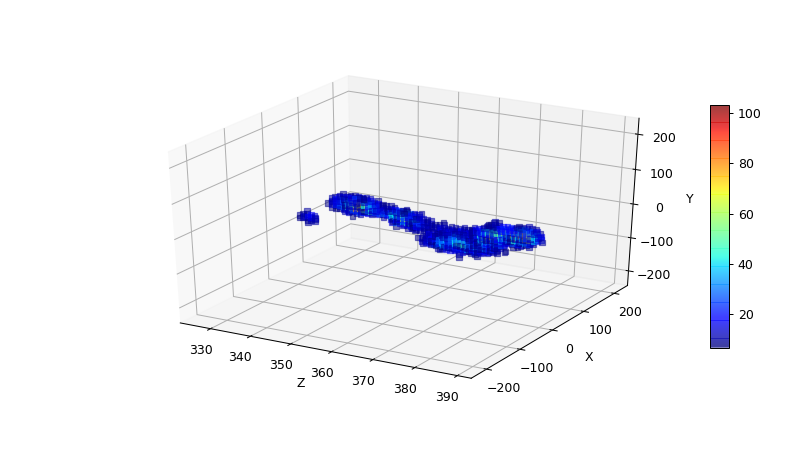

In [8]:
im = IMAGE(imdf, datasipm, run, ev, typo)
im.plot3d()
im.fig.show();

# 2. EVENT SELECTION AND PERCENTAGES

In [9]:
typo='Tlds'
df = pd.HDFStore(f'../corrections_6206_{typo}.h5')['/edf']

Emax, Emin = 420e3, 380e3
edf = df[(df.e<Emax) & (df.e>Emin)]

def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

nbins=100
ydata, xdata = np.histogram(edf['e'], bins=nbins, range=(Emin, Emax))
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(edf['e']), np.std(edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                               bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

In [12]:
# Percentages
Ea_pk, Eb_pk = 390e3, 410e3 #integration region

It,_ = quad(F, Ea_pk, Eb_pk, args=tuple(popt))
I1e = (Eb_pk-Ea_pk)*(m*(Ea_pk-Emin)+c + 0.5*(m*Eb_pk-m*Ea_pk))

e1, e2 = I1e/It, 1-I1e/It

<IPython.core.display.Javascript object>


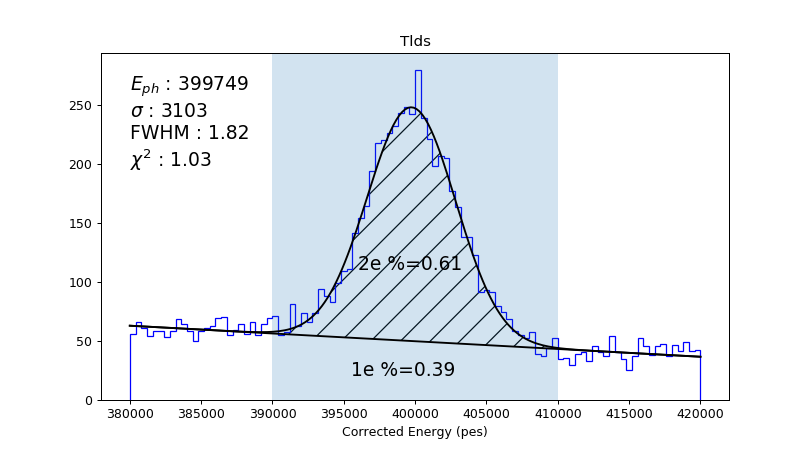

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(edf['e'], bins=nbins, color='b', histtype='step');
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'black');
ax.plot(E, m*(E-Emin)+c, color='black');

E = np.linspace(Ea_pk, Eb_pk, 2*nbins);
ax.fill_between(E, m*(E-Emin)+c, F(E, *popt), hatch='/', alpha=0);
#ax.fill()

rect = patches.Rectangle(xy=(Ea_pk,0), width=Eb_pk-Ea_pk, height=300, alpha=0.2)
ax.add_patch(rect)


t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(380e3, 200, s = t, fontsize = 15);

t1 = (f'1e %={round(e1,2)}')
ax.text(395.5e3, 20, s = t1, fontsize = 15);

t2 = (f'2e %={round(e2,2)}')
ax.text(396e3, 110, s = t2, fontsize = 15, color='black');


ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(typo));
fig.show()

In [13]:
print(Ea, Eb)

396645.6520478346 402853.128102854


In [14]:
#event selection (notice that selection is over peak 0)
ipk = 0
evtsdf = df[(df.e<Eb) & (df.e>Ea) & (df.peak==ipk)][['event', 'peak', 'loc']]

## Rebinned and blob selected image

In [15]:
evtsdf = evtsdf.reset_index(drop=True)

In [17]:
i = 6
ev, ipk, loc = evtsdf['event'][i], evtsdf['peak'][i], evtsdf['loc'][i]

datadir  = f'/home/gonzalo/Documentos/NEXT/CsThNB/GDL/selected_pmaps/{run}/pmaps_{loc}_{run}_{typo}.h5'
data     = pd.HDFStore(datadir)

s1   , s2   , s2si    = data['s1']      , data['s2']      , data['s2si']
s1_ev = s1[(s1.event==ev)&(s1.peak==ipk)]
s2_ev, s2si_ev = s2[(s2.event==ev)&(s2.peak==ipk)], s2si[(s2si.event==ev)&(s2si.peak==ipk)]

pmap=(s1_ev, s2_ev, s2si_ev)
x0ij, y0ij, z0ij, eij, qij = hppmap.get_event_hits(pmap, calibrate, xpos, ypos)

imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = x0ij, y0ij, z0ij, eij

rx, ry = 1, 1
zd = -1
imdf = vx.imageDataFrame(imagedf, datasipm, rx, ry, zd, th=0)

<IPython.core.display.Javascript object>


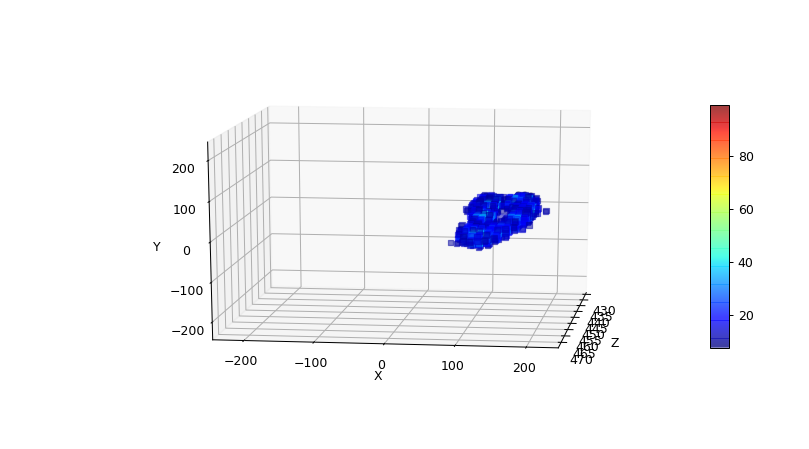

In [18]:
im = IMAGE(imdf, datasipm, run, ev, typo)
im.plot3d(th=10)
im.fig.show();

In [19]:
ax = im.fig.axes[0]
R=15

In [20]:
Eb=[]
i=0
while i<1:
    blobdf, imdf_nb = b.blob(imdf, R)
    
    X, Y, Z = blobdf['X'], blobdf['Y'], blobdf['Z']
    ax.scatter(Z, X, Y, c='black', s=20)
    
    Eb.append(blobdf['E'].sum())
    imdf = imdf_nb
    i+=1

In [21]:
im.fig.show()

# 3. BLOB CALCULATION

In [23]:
rx, ry = 1, 1
zd = -1
R=10

In [24]:
run  = 6206
typo = 'Tlds'

datasipm = DataSiPM(run)
xpos, ypos = datasipm.X.values, datasipm.Y.values
correction_filename = f'/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5'
calibrate = corrections.Calibration(correction_filename, 'scale')

calibration file : /home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run6206.h5
node             : scale
Energy   scale : 10069.6 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale : 598.7 (pes)


In [25]:
blobsdf = pd.DataFrame(columns=['event', 'peak', 'E1', 'E2', 'E3'])

In [ ]:
j=1
# LOOP IN EVENTS
for ev, ipk, loc in zip(evtsdf['event'], evtsdf['peak'], evtsdf['loc']):
    datadir  = f'/home/gonzalo/Documentos/NEXT/CsThNB/GDL/selected_pmaps/{run}/pmaps_{loc}_{run}_{typo}.h5'
    data     = pd.HDFStore(datadir)
    
    s1   , s2   , s2si    = data['s1']      , data['s2']      , data['s2si']
    
    s1_ev = s1[(s1.event==ev)&(s1.peak==ipk)]
    s2_ev, s2si_ev = s2[(s2.event==ev)&(s2.peak==ipk)], s2si[(s2si.event==ev)&(s2si.peak==ipk)]
    
    pmap=(s1_ev, s2_ev, s2si_ev)
    x0ij, y0ij, z0ij, eij, _ = hppmap.get_event_hits(pmap, calibrate, xpos, ypos)
    
    imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
    imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = x0ij, y0ij, z0ij, eij

    # EVENT VOXELIZATION
    imdf = vx.imageDataFrame(imagedf, datasipm, rx, ry, zd, th=0)
    
    #EVENT BLOB CALC
    Eb=[]
    i=0
    while i<3:
        blobdf, imdf_nb = b.blob(imdf, R)
        Eb.append(blobdf['E'].sum())
        imdf = imdf_nb
        i+=1
        
    blobsdf = blobsdf.append({'event':ev, 'peak':ipk, 'E1':Eb[0], 'E2':Eb[1], 'E3':Eb[2]}, ignore_index=True)
    
    print(f'Events saved:{j}/{len(evtsdf)}', end = '\r')
    j+=1

In [28]:
if zd<0: filename=f'blobsdf_{run}_{typo}_{R}_{rx}_{ry}_no.h5'
else   : filename=f'blobsdf_{run}_{typo}_{R}_{rx}_{ry}_{zd}.h5'
blobsdf.to_hdf(filename, key = 'blobs')

# 4. BLOB ANALYSIS

In [18]:
run, typo, R, rx, ry, zd = 6206, 'Tlds', 10, 1, 1, 'no'
bdf = pd.HDFStore(f'blobsdf_{run}_{typo}_{R}_{rx}_{ry}_{zd}.h5')['blobs']

In [19]:
nbins=100

<IPython.core.display.Javascript object>


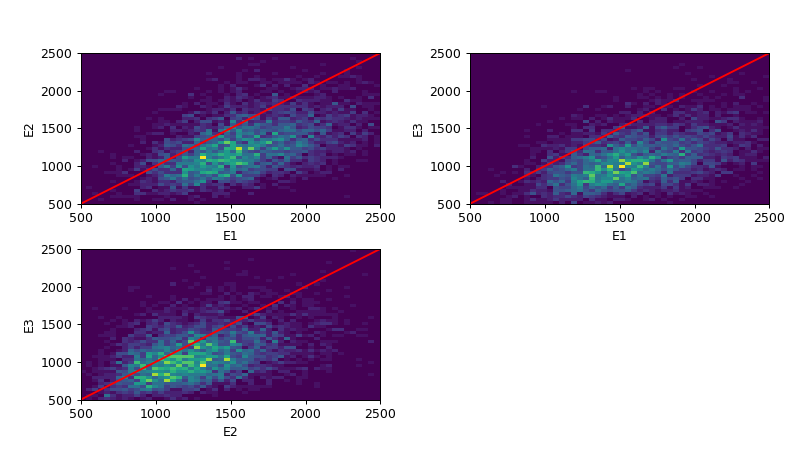

In [23]:
fig = plt.figure(constrained_layout=True)
gs  = gridspec.GridSpec(ncols=2, nrows=2, left=0.1, right=0.95, wspace=0.3, hspace=0.3)
ax12 = fig.add_subplot(gs[0,0])
ax13 = fig.add_subplot(gs[0,1])
ax23 = fig.add_subplot(gs[1,0])

El, Eu = 5e2, 2.5e3
E =np.linspace(El, Eu, 200)

ax12.hist2d(bdf['E1'], bdf['E2'], bins=.5*nbins, range=((El, Eu),(El, Eu)));
ax12.plot(E, E, c='r')
ax12.set_xlabel('E1');
ax12.set_ylabel('E2');

ax13.hist2d(bdf['E1'], bdf['E3'], bins=.5*nbins, range=((El, Eu),(El, Eu)));
ax13.plot(E, E, c='r')
ax13.set_xlabel('E1');
ax13.set_ylabel('E3');

ax23.hist2d(bdf['E2'], bdf['E3'], bins=.5*nbins, range=((El, Eu),(El, Eu)));
ax23.plot(E, E, c='r')
ax23.set_xlabel('E2');
ax23.set_ylabel('E3');

fig.show();